In [1]:
import os
import random
from itertools import product
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, precision_recall_fscore_support
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, smart_resize
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# *Data Preparation and Exploration*

In [2]:
def load_image_dataset(folder_path):
    images = []
    labels = []
    for file in os.listdir(folder_path):
        image_path = os.path.join(folder_path, file)
        image = load_img(image_path, target_size=(100,100))
        image_array = img_to_array(image)
        image_array_normalized = image_array/255.0
        images.append(image_array_normalized)
        if 'no_tumor' in folder_path:
            labels.append('no_tumor')
        elif 'glioma_tumor' in folder_path:
            labels.append('glioma_tumor')
        elif 'meningioma_tumor' in folder_path:
            labels.append('meningioma_tumor')
        elif 'pituitary_tumor' in folder_path:
            labels.append('pituitary_tumor')     
    return np.array(images), np.array(labels)

def display_random_images(images, labels):
    plt.figure(figsize=(10, 7))
    random_indices = np.random.choice(2349, size=6, replace=False) 
    for i, idx in enumerate(random_indices):
        image_label = labels[idx]
        if image_label == 'no_tumor':
            label = 'No Tumor'
        elif image_label == 'glioma_tumor':
            label = 'Glioma Tumor'
        elif image_label == 'meningioma_tumor':
            label = 'Meningioma Tumor'
        elif image_label == 'pituitary_tumor':
            label = 'Pituitary Tumor'
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[idx])
        plt.axis('off')
        plt.title(f"Image {idx} ({label})") 
    plt.tight_layout()
    plt.show()

In [3]:
classes = ['no_tumor', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']
class_map = {'no_tumor': 0, 'glioma_tumor': 1, 'meningioma_tumor': 2, 'pituitary_tumor': 3}
X_train = None  
y_train = None
X_test = None  
y_test = None

for label in classes:
    train_path = f'Brain-Tumor-MRI-Data/Training/{label}'
    train_mri, train_labels = load_image_dataset(train_path)
    
    if X_train is None:
        X_train = train_mri
        y_train = train_labels
    else:
        X_train = np.concatenate((X_train, train_mri), axis=0)
        y_train = np.concatenate((y_train, train_labels), axis=0)

    test_path = f'Brain-Tumor-MRI-Data/Testing/{label}'
    test_mri, test_labels = load_image_dataset(test_path)
    
    if X_test is None:
        X_test = test_mri
        y_test = test_labels
    else:
        X_test = np.concatenate((X_test, test_mri), axis=0)
        y_test = np.concatenate((y_test, test_labels), axis=0)

X_all = np.concatenate((X_train, X_test), axis=0)
y_all = np.concatenate((y_train, y_test), axis=0)
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.1, random_state=2024, stratify=y_all)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2024, stratify=y_train)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(2349, 100, 100, 3)
(588, 100, 100, 3)
(327, 100, 100, 3)


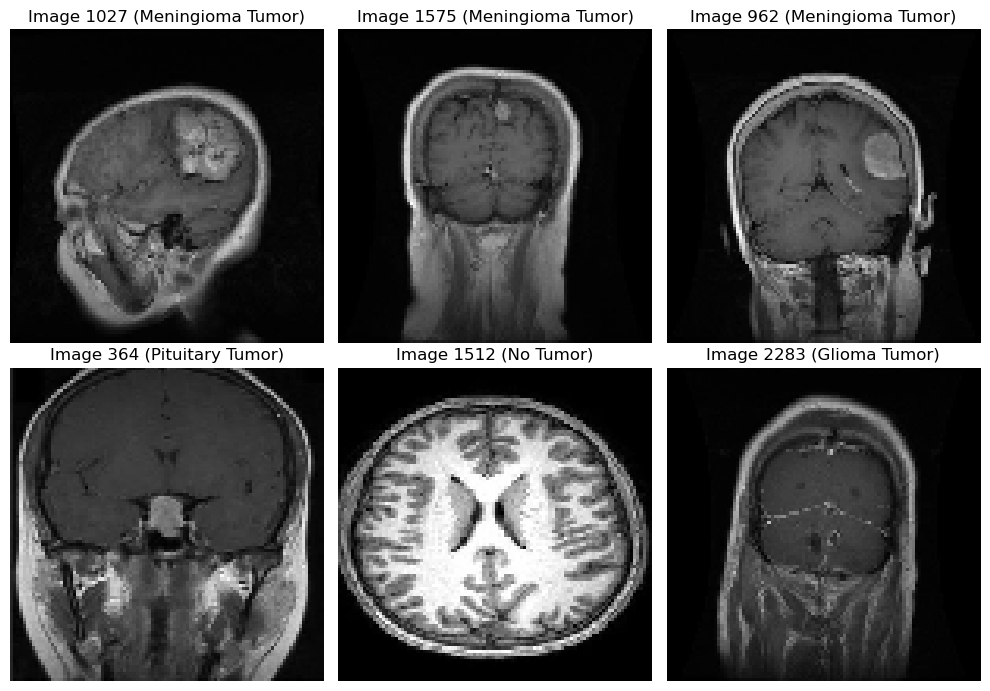

In [4]:
display_random_images(X_train, y_train)

In [5]:
def crop_black_space(img, threshold=0.25, padding=10):
    mask = np.any(img > threshold, axis=-1)
    if not np.any(mask):
        return img

    coords = np.argwhere(mask)
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)

    y_min = max(y_min - padding, 0)
    x_min = max(x_min - padding, 0)
    y_max = min(y_max + padding, img.shape[0] - 1)
    x_max = min(x_max + padding, img.shape[1] - 1)

    cropped = img[y_min:y_max+1, x_min:x_max+1]
    cropped = smart_resize(cropped, (100,100))
    return cropped

In [6]:
X_train_cropped = []
X_val_cropped = []
X_test_cropped = []

for img in X_train:
    img_cropped = crop_black_space(img)
    X_train_cropped.append(img_cropped)

for img in X_val:
    img_cropped = crop_black_space(img)
    X_val_cropped.append(img_cropped)
    
for img in X_test:
    img_cropped = crop_black_space(img)
    X_test_cropped.append(img_cropped)

X_train_cropped = np.array(X_train_cropped)
X_val_cropped = np.array(X_val_cropped)
X_test_cropped = np.array(X_test_cropped)

CROPPED IMAGE DISPLAY


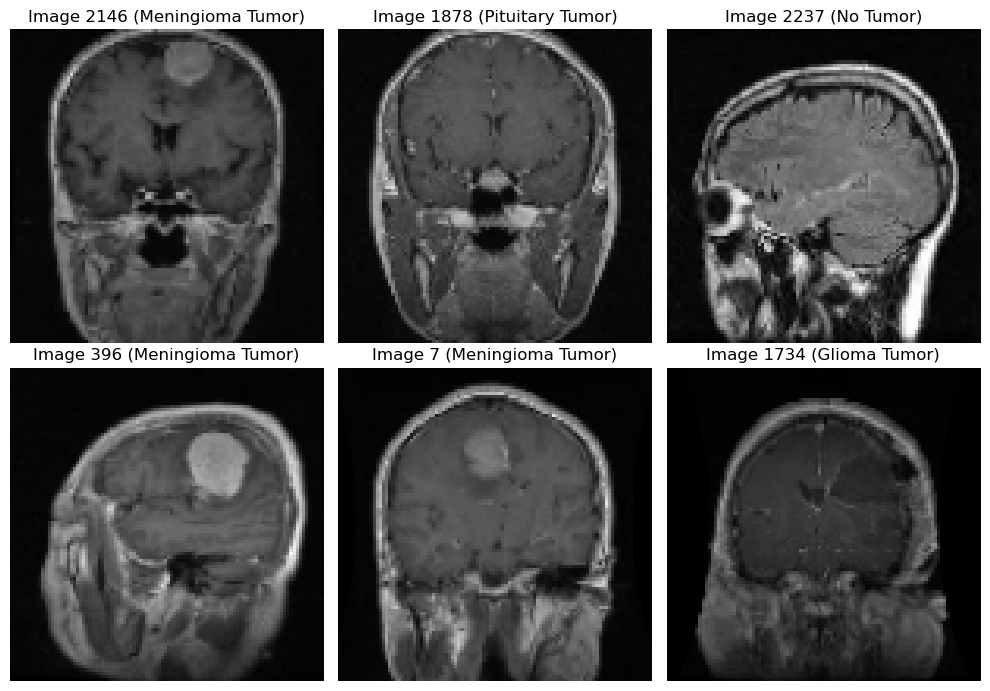

In [123]:
print('CROPPED IMAGE DISPLAY')
display_random_images(X_train_cropped, y_train)

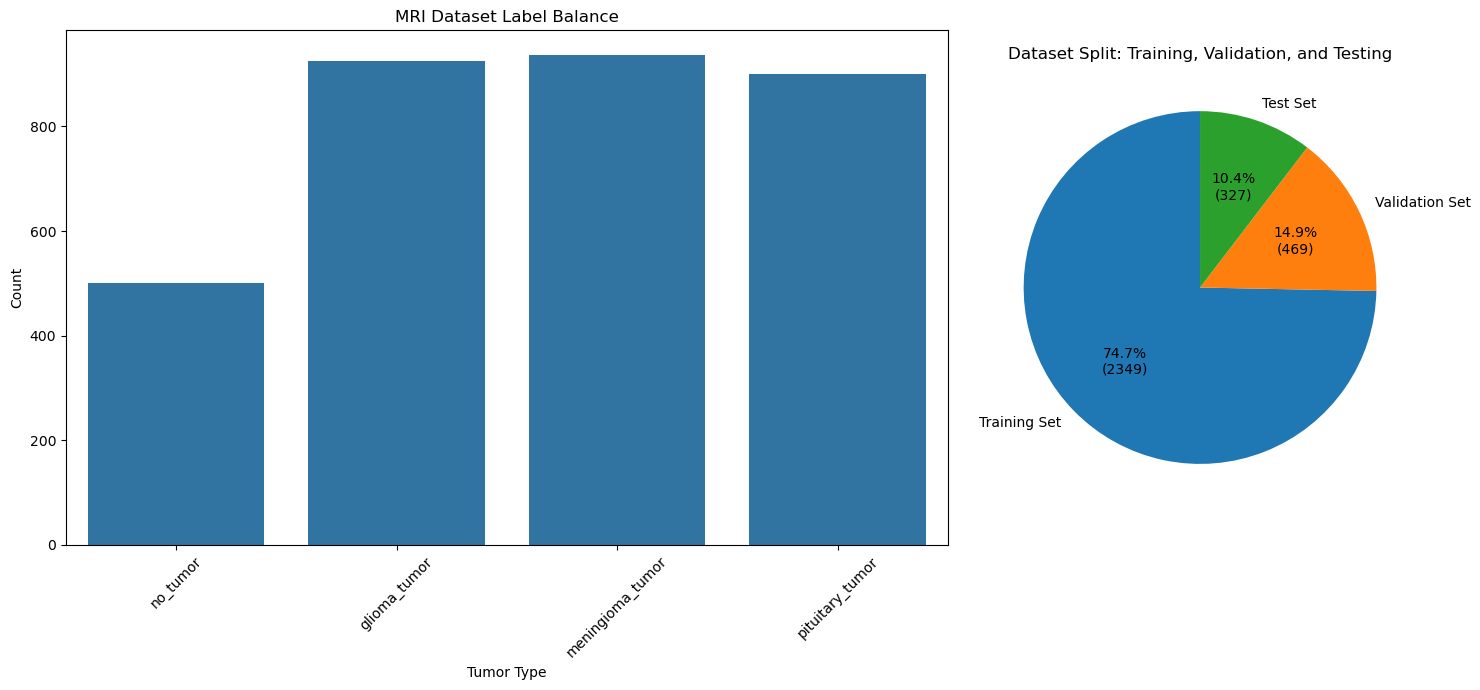

In [134]:
y_train_series = pd.Series(y_train)
y_test_series = pd.Series(y_test)

label_map = {0: 'No Tumor', 1: 'Glioma Tumor', 2: 'Meningioma Tumor', 3: 'Pituitary Tumor'}
y_train_categorical = y_train_series.map(label_map)
y_test_categorical = y_test_series.map(label_map)

fig = plt.figure(figsize=(15, 7))

grid = fig.add_gridspec(1, 2, width_ratios=[2, 1])

ax1 = fig.add_subplot(grid[0, 0])
sns.countplot(x=y_all, ax=ax1)
ax1.set_title("MRI Dataset Label Balance")
ax1.set_xlabel("Tumor Type")
ax1.set_ylabel("Count")
ax1.tick_params(axis='x', rotation=45)

ax2 = fig.add_subplot(grid[0, 1])
sizes = [len(y_train), len(y_val), len(y_test)]
labels = ['Training Set', 'Validation Set', 'Test Set']

def autopct_format(pct, all_values):
    absolute = int(round(pct / 100.0 * sum(all_values)))
    return f"{pct:.1f}%\n({absolute})"

ax2.pie(sizes, labels=labels, autopct=lambda pct: autopct_format(pct, sizes), startangle=90)
ax2.set_title("Dataset Split: Training, Validation, and Testing")

plt.tight_layout()
plt.show()

# *Finding the Optimal Network Architecture*

In [9]:
y_train_int = np.array([class_map[label] for label in y_train])
y_val_int = np.array([class_map[label] for label in y_val])
y_test_int = np.array([class_map[label] for label in y_test])

y_train_categorical = to_categorical(y_train_int, num_classes=4)
y_val_categorical = to_categorical(y_val_int, num_classes=4)
y_test_categorical = to_categorical(y_test_int, num_classes=4)

In [10]:
conv_layers = [3, 4]
filter_sizes = [(2,2), (3,3)]
num_filters = [8, 16]
dropout_rates = [0.05, 0.25]
batch_sizes = [8, 16]
l2_reg = 0.001

hyper_params = list(product(conv_layers, filter_sizes, num_filters, dropout_rates, batch_sizes))

cv_results = {param_config: [] for param_config in hyper_params}
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=24)
for subtrain_index, val_index in stratified_kfold.split(X_train_cropped, y_train_int):
    X_subtrain, X_val = X_train_cropped[subtrain_index], X_train_cropped[val_index]
    y_subtrain, y_val = y_train_int[subtrain_index], y_train_int[val_index]
    y_subtrain = to_categorical(y_subtrain, num_classes=4)
    y_val = to_categorical(y_val, num_classes=4)
    best_accuracy = 0
    
    for param_config in hyper_params:
        model_cnn = Sequential()
        model_cnn.add(Input(shape=(100, 100, 3)))
        model_cnn.add(Conv2D(filters=param_config[2], kernel_size=param_config[1], activation='relu', kernel_regularizer=l2(l2_reg)))
        model_cnn.add(MaxPooling2D(pool_size=(2,2)))
        for i in range(2, param_config[0] + 1):
            model_cnn.add(Conv2D(filters=int(param_config[2]*(2**i)), kernel_size=param_config[1], activation='relu', kernel_regularizer=l2(l2_reg)))
            model_cnn.add(MaxPooling2D(pool_size=(2,2)))    
        model_cnn.add(Flatten())
        model_cnn.add(Dense(128, kernel_regularizer=l2(l2_reg)))
        model_cnn.add(Dropout(param_config[3]))
        model_cnn.add(Dense(4))
        model_cnn.add(Activation('softmax'))

        class_weight = {0: 1.0, 1: 2.5, 2: 1.0, 3: 1.0}
        model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
        config_history = model_cnn.fit(X_subtrain, y_subtrain, validation_data=(X_val, y_val), batch_size=param_config[4], epochs=10, verbose=0, callbacks=[early_stopping])
        val_accuracy = config_history.history['val_accuracy'][-1]
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_config = param_config
            
    cv_results[best_config].append(val_accuracy)

results_data = []

for config, scores in cv_results.items():
    num_times_chosen = len(scores)  
    mean_score = np.mean(scores) if scores else np.nan  
    results_data.append({'# Conv. Layers': config[0], 
                           'Filter Size': config[1], 
                           'Number of Filters': list(config[2]*(2**i) for i in range(0, config[0])),
                           'Dropout Rates': config[3],
                           'Batch Sizes': config[4], 
                           'Number of Times Chosen': num_times_chosen, 
                           'Mean Accuracy': mean_score})

results_df = pd.DataFrame(results_data)
results_df = results_df.sort_values(by=['Number of Times Chosen', 'Mean Accuracy'], ascending=False)
results_df = results_df[results_df['Mean Accuracy'].notna()]
results_df

,# Conv. Layers,Filter Size,Number of Filters,Dropout Rates,Batch Sizes,Number of Times Chosen,Mean Accuracy
26,4,"(3, 3)","[8, 16, 32, 64]",0.25,8,2,0.845745
25,4,"(3, 3)","[8, 16, 32, 64]",0.05,16,1,0.872068
27,4,"(3, 3)","[8, 16, 32, 64]",0.25,16,1,0.851064
24,4,"(3, 3)","[8, 16, 32, 64]",0.05,8,1,0.808511


# *Evaluating the Optimal CNN Model* 

In [36]:
optimal_num_layers = results_df.iloc[0,0]
optimal_filter_size = results_df.iloc[0,1]
optimal_num_filters = int(results_df.iloc[0,2][0])
optimal_dropout_rate = results_df.iloc[0,3]
optimal_batch_size = results_df.iloc[0,4]
l2_reg = 0.001 

optimal_cnn = Sequential()
optimal_cnn.add(Input(shape=(100, 100, 3)))
optimal_cnn.add(Conv2D(filters=optimal_num_filters, kernel_size=optimal_filter_size, activation='relu', kernel_regularizer=l2(l2_reg)))
optimal_cnn.add(MaxPooling2D(pool_size=(2,2)))
for i in range(1, optimal_num_layers):
    optimal_cnn.add(Conv2D(filters=int(optimal_num_filters*(2**i)), kernel_size=optimal_filter_size, activation='relu', kernel_regularizer=l2(l2_reg)))
    optimal_cnn.add(MaxPooling2D(pool_size=(2,2)))    
optimal_cnn.add(Flatten())
optimal_cnn.add(Dense(128, kernel_regularizer=l2(l2_reg)))
optimal_cnn.add(Dropout(optimal_dropout_rate))
optimal_cnn.add(Dense(4))
optimal_cnn.add(Activation('softmax'))

class_weight = {0: 1.0, 1: 3.0, 2: 1.0, 3: 1.0}
optimal_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)

history = optimal_cnn.fit(X_train_cropped, y_train_categorical, validation_data=(X_val_cropped, y_val_categorical), batch_size=optimal_batch_size, epochs=100, verbose=1, callbacks=[early_stopping])
val_loss, val_acc = optimal_cnn.evaluate(X_val_cropped, y_val_categorical, verbose=0)
print("Validation Accuracy:", val_acc)

Epoch 1/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.3618 - loss: 1.4958 - val_accuracy: 0.5051 - val_loss: 1.2126
Epoch 2/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6524 - loss: 0.9610 - val_accuracy: 0.6939 - val_loss: 0.8638
Epoch 3/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7523 - loss: 0.7601 - val_accuracy: 0.7432 - val_loss: 0.8161
Epoch 4/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8228 - loss: 0.6222 - val_accuracy: 0.7568 - val_loss: 0.8027
Epoch 5/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8744 - loss: 0.5053 - val_accuracy: 0.7738 - val_loss: 0.7112
Epoch 6/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8885 - loss: 0.4537 - val_accuracy: 0.8163 - val_loss: 0.7135
Epoch 7/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9167 - loss: 0.3973 - val_accuracy: 0.8078 - val_loss: 0.7466
Epoch 8/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9379 - loss: 0.3435 - val_accu

Multiclass Results (No Tumor vs Glioma vs Meningioma vs Pituitary)
Multiclass Test Accuracy: 0.9113149847094801
Multiclass Test Precision: 0.9128609089950438
Multiclass Test Recall: 0.9113149847094801
Multiclass F1-score: 0.9116993949745261
Multiclass AUC-ROC: 0.9810943978773052

Binary Results (No Tumor vs Tumor):
Binary Accuracy: 0.9694189602446484
Binary Precision: 0.9819494584837545
Binary Recall: 0.9819494584837545
Binary F1-score: 0.9819494584837545
Binary AUC-ROC: 0.9951624548736462


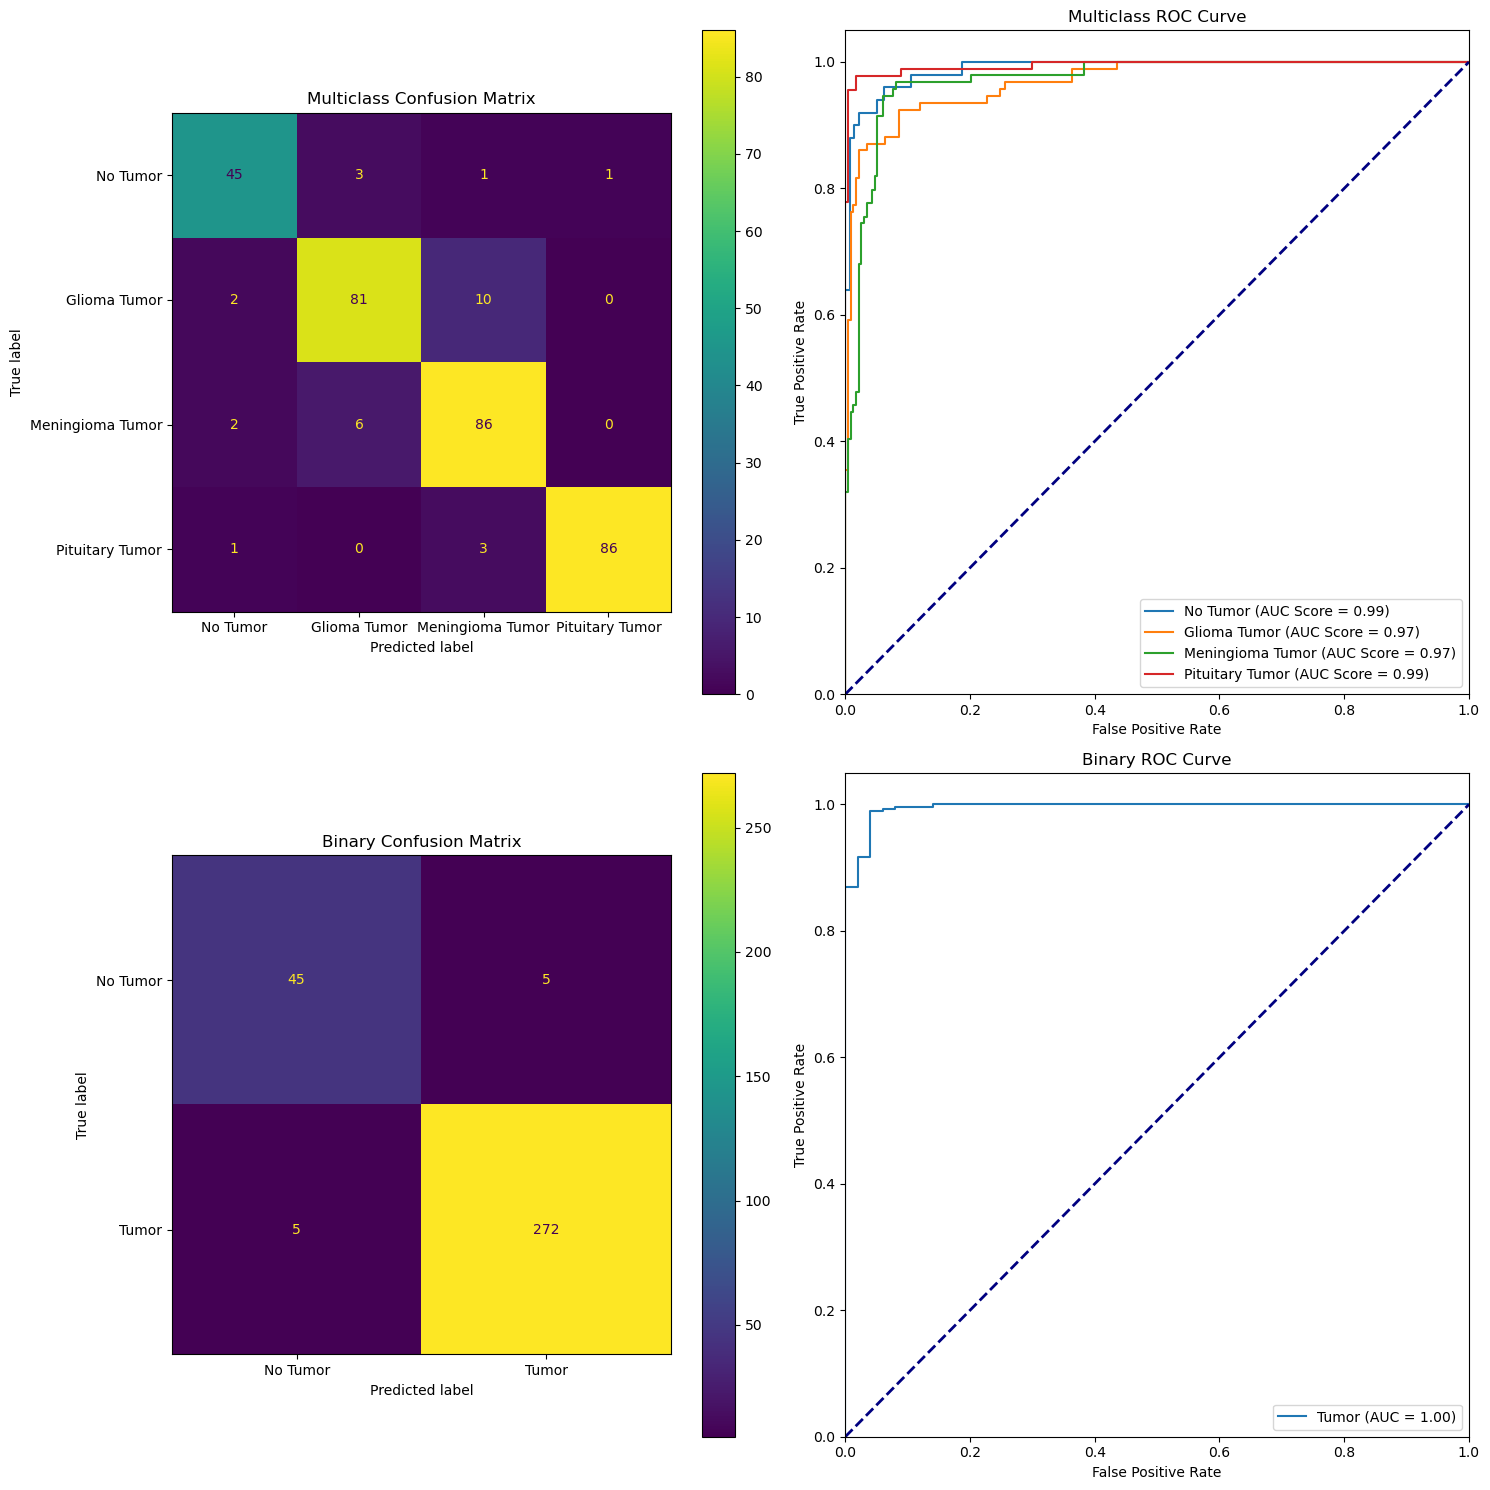

In [37]:
y_pred_prob = optimal_cnn.predict(X_test_cropped, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)                                            

test_accuracy = np.mean(y_test_int == y_pred)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(y_test_int, y_pred, average='weighted')
test_auc = roc_auc_score(y_test_categorical, y_pred_prob, multi_class='ovr')

y_test_binary = (y_test_int != 0).astype(int)
y_pred_binary = (y_pred != 0).astype(int)

bin_accuracy = np.mean(y_test_binary == y_pred_binary)
bin_precision, bin_recall, bin_f1, _ = precision_recall_fscore_support(y_test_binary, y_pred_binary, average='binary')
binary_auc = roc_auc_score(y_test_binary, p_tumor)

print("Multiclass Results (No Tumor vs Glioma vs Meningioma vs Pituitary)")
print("Multiclass Test Accuracy:", test_accuracy)
print("Multiclass Test Precision:", test_precision)
print("Multiclass Test Recall:", test_recall)
print("Multiclass F1-score:", test_f1)
print("Multiclass AUC-ROC:", test_auc)
print("")

print("Binary Results (No Tumor vs Tumor):")
print("Binary Accuracy:", bin_accuracy)
print("Binary Precision:", bin_precision)
print("Binary Recall:", bin_recall)
print("Binary F1-score:", bin_f1)
print("Binary AUC-ROC:", binary_auc)

fig, ax = plt.subplots(2, 2, figsize=(15, 15))

y_test_mapped = pd.Series(y_test).map(label_map)
y_pred_mapped = pd.Series(y_pred).map(label_map)
labels = list(label_map.values())

conf_matrix = confusion_matrix(y_test_int, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
disp.plot(ax=ax[0,0], values_format='d')
ax[0,0].set_title('Multiclass Confusion Matrix')

for i in range(4):
    fpr, tpr, thresh = roc_curve(y_test_categorical[:, i], y_pred_prob[:, i])
    class_auc = roc_auc_score(y_test_categorical[:, i], y_pred_prob[:, i])
    ax[0,1].plot(fpr, tpr, label=f"{label_map[i]} (AUC Score = {class_auc:.2f})")
ax[0,1].plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
ax[0,1].set_xlim([0.0,1.0])
ax[0,1].set_ylim([0.0,1.05])
ax[0,1].set_title('Multiclass ROC Curve')
ax[0,1].set_xlabel('False Positive Rate')
ax[0,1].set_ylabel('True Positive Rate')
ax[0,1].legend(loc='lower right')

bin_conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)
bin_disp = ConfusionMatrixDisplay(confusion_matrix=bin_conf_matrix, display_labels=["No Tumor", "Tumor"])
bin_disp.plot(ax=ax[1,0], values_format='d')
ax[1,0].set_title('Binary Confusion Matrix')

fpr_bin, tpr_bin, thresholds_bin = roc_curve(y_test_binary, p_tumor)
ax[1,1].plot(fpr_bin, tpr_bin, label=f"Tumor (AUC = {binary_auc:.2f})")
ax[1,1].plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
ax[1,1].set_xlim([0.0,1.0])
ax[1,1].set_ylim([0.0,1.05])
ax[1,1].set_title('Binary ROC Curve')
ax[1,1].set_xlabel('False Positive Rate')
ax[1,1].set_ylabel('True Positive Rate')
ax[1,1].legend(loc='lower right')

plt.tight_layout()
plt.show()

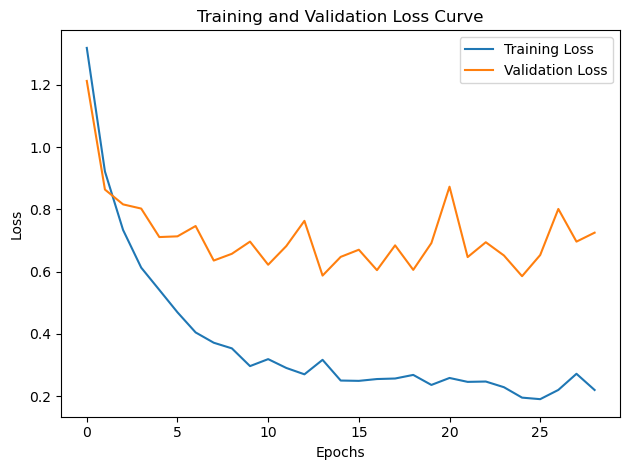

In [40]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [56]:
optimal_cnn.summary()

Model: "sequential_164"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_576 (Conv2D)             │ (None, 98, 98, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_576               │ (None, 49, 49, 8)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_577 (Conv2D)             │ (None, 47, 47, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_577               │ (None, 23, 23, 16)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_578 (Conv2D)             │ (None, 21, 21, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_578               │ (None, 10, 10, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_579 (Conv2D)             │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_579               │ (None, 4, 4, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_164 (Flatten)           │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_328 (Dense)               │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_168 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_329 (Dense)               │ (None, 4)              │           516 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_164 (Activation)     │ (None, 4)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 468,734 (1.79 MB)

 Trainable params: 156,244 (610.33 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 312,490 (1.19 MB)

# *Interpreting the CNN* 

In [148]:
def display_feature_maps(class_name, n_cols=8):
    indices = [i for i, label in enumerate(y_test) if label == class_name]
    if not indices:
        print(f"No samples found for class '{class_name}' in the test set.")
        return
    
    random_index = random.choice(indices)
    sample_image = X_test[random_index:random_index + 1]
    
    _ = optimal_cnn.predict(sample_image)
    
    conv_layers = [layer for layer in optimal_cnn.layers if 'conv' in layer.name]
    if len(conv_layers) < 4:
        print("The model has fewer than 4 convolutional layers.")
        return
    
    activation_model = Model(inputs=optimal_cnn.layers[0].input, outputs=[conv_layers[0].output, conv_layers[1].output, conv_layers[2].output, conv_layers[3].output])
    activations = activation_model.predict(sample_image)
    
    first_layer_activation, second_layer_activation, third_layer_activation, fourth_layer_activation = activations
    
    def plot_feature_maps(layer_activation, layer_name, ax_start, offset=0):
        n_features = layer_activation.shape[-1]
        n_rows = (8 + n_cols - 1) // n_cols  # Always show 8 filters
        
        for i in range(8):
            row = (ax_start + i + offset) // n_cols
            col = (ax_start + i + offset) % n_cols
            axs[row, col].imshow(layer_activation[0, :, :, i], cmap='viridis')
            axs[row, col].set_title(f'{layer_name}\nFilter {i}', fontsize=8)
            axs[row, col].axis('off')
        return ax_start + 8
    
    total_rows = 4  # 4 convolutional layers, 8 filters each
    fig, axs = plt.subplots(total_rows, n_cols, figsize=(n_cols * 2, total_rows * 2))
    
    fig.suptitle(f'Feature Maps for Class: {class_name}\nImage Index: {random_index}', fontsize=16)
    
    current_start = 0
    current_start = plot_feature_maps(first_layer_activation, "Conv Layer 1", current_start)
    current_start = plot_feature_maps(second_layer_activation, "Conv Layer 2", current_start)
    current_start = plot_feature_maps(third_layer_activation, "Conv Layer 3", current_start)
    plot_feature_maps(fourth_layer_activation, "Conv Layer 4", current_start)
    
    for i in range(current_start, total_rows * n_cols):
        axs[i // n_cols, i % n_cols].axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


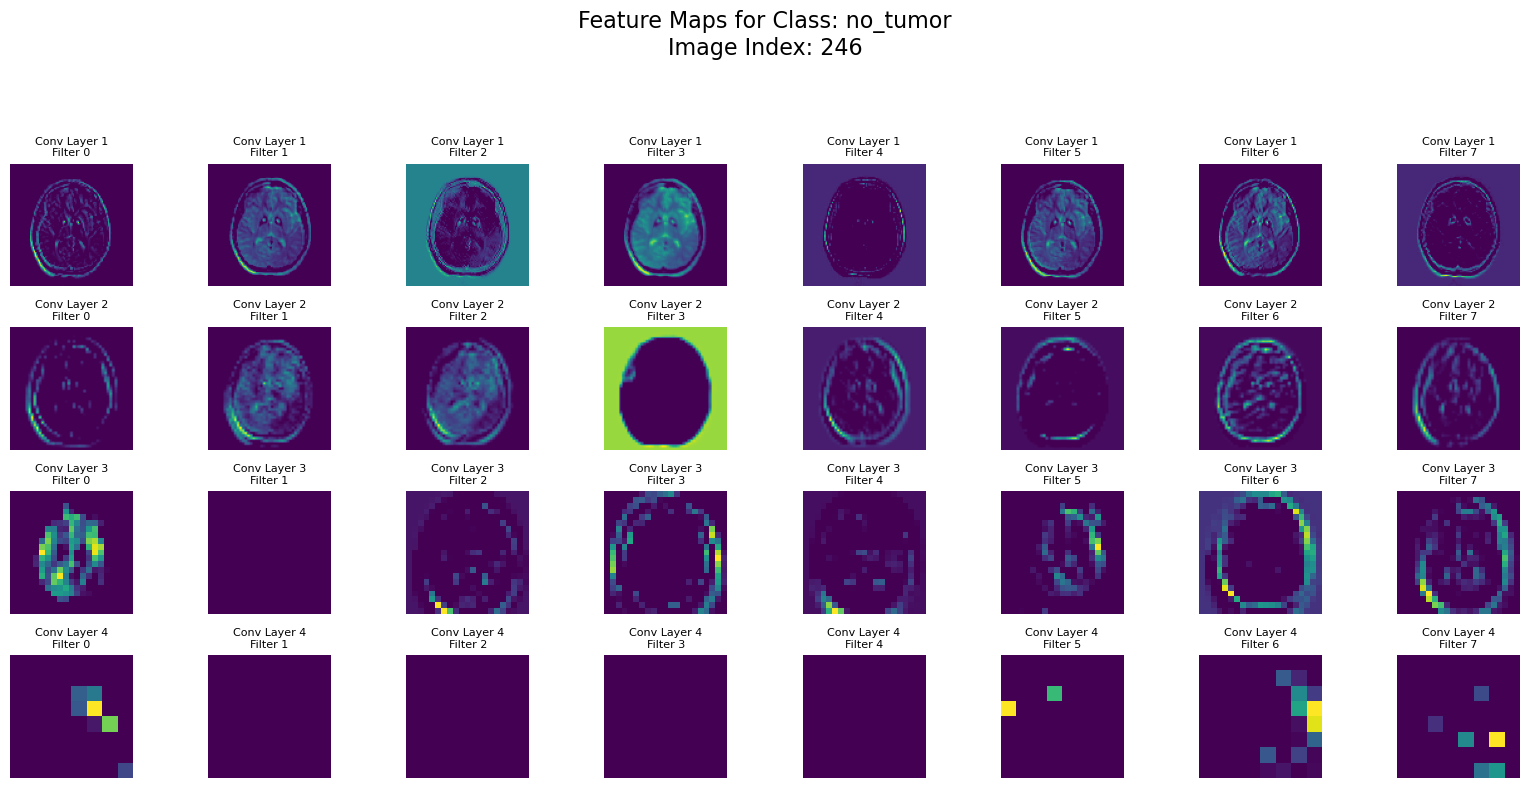

In [164]:
display_feature_maps('no_tumor')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


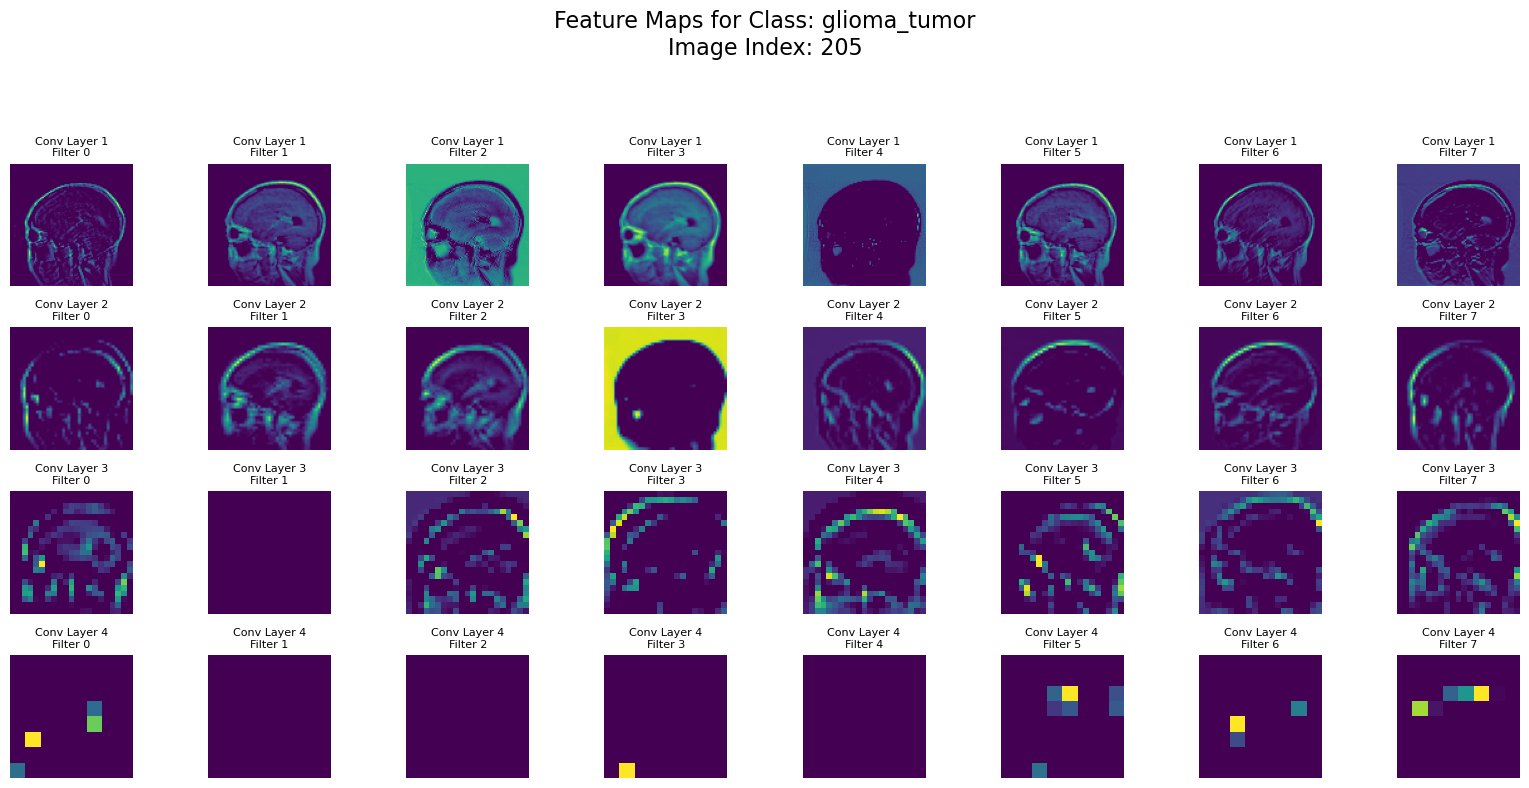

In [169]:
display_feature_maps('glioma_tumor')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


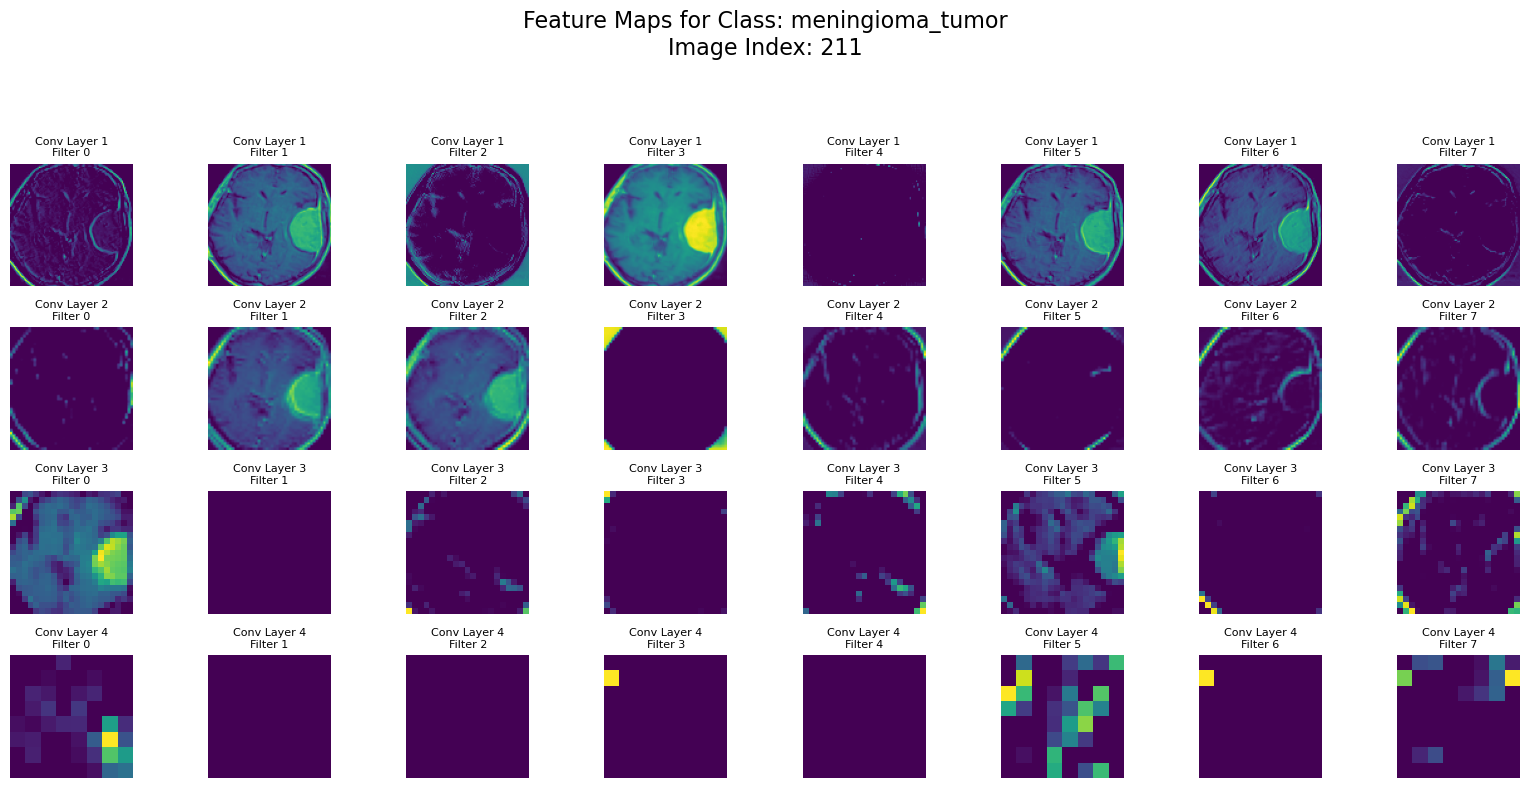

In [161]:
display_feature_maps('meningioma_tumor')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


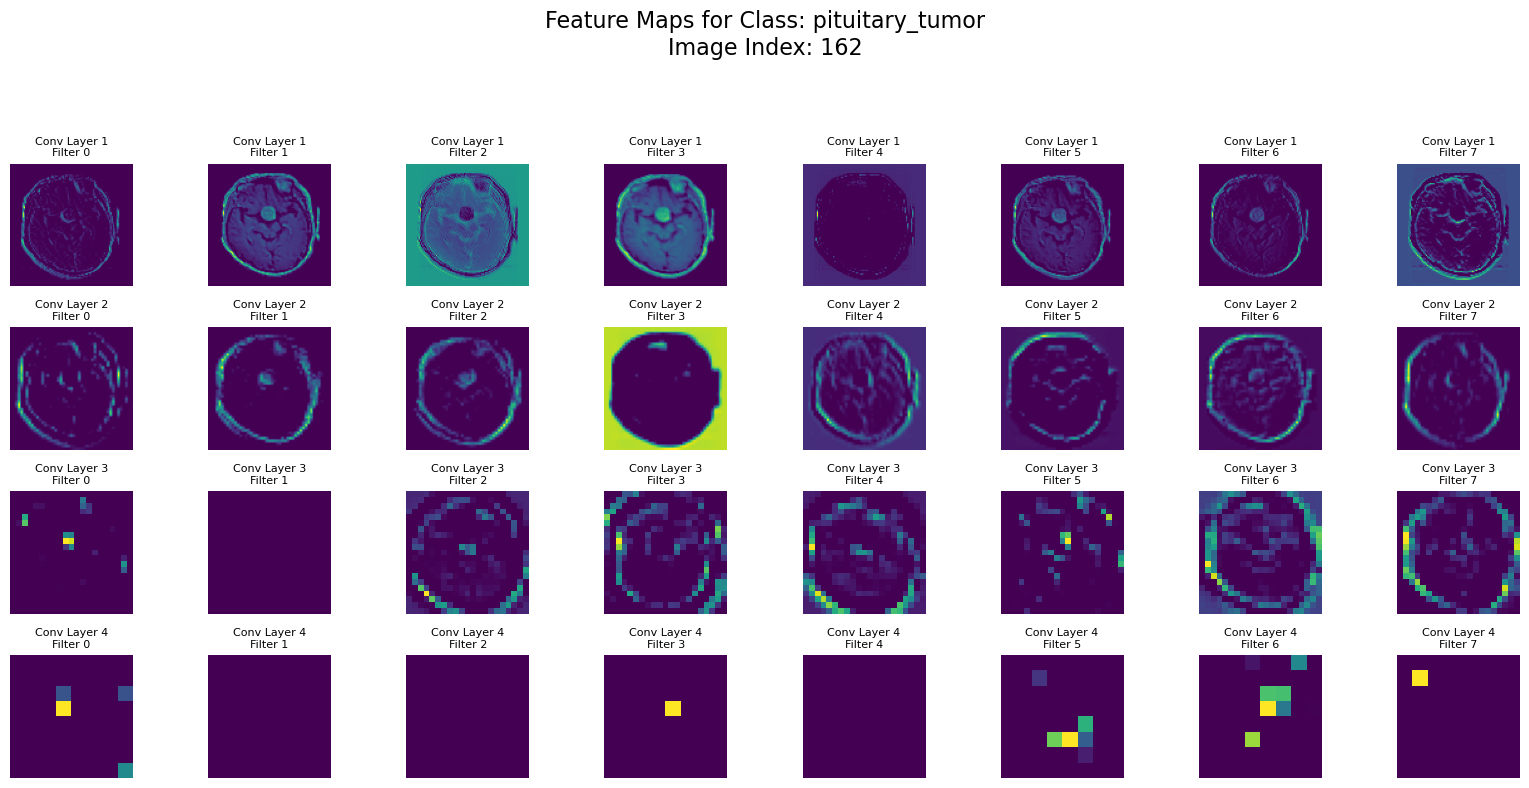

In [163]:
display_feature_maps('pituitary_tumor')